In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras.backend as K
from tensorflow.keras import Model

import matplotlib.pyplot as plt
from PIL import Image
import glob
import numpy as np


# Autoencoder transfer style
Ce notebook est une implémentation de l'architecture décrite par A. Sanakoyeu, D. Kotovenko, S. Lang et B. Ommer dans *A Style-Aware Content Loss for Real-time HD Style Transfer* (2018).

<p align="center">
    <img src='../latex/images/autoencoder.png'  />
</p>

In [2]:
input_size = (128, 128, 3)
input_content = tfl.Input(input_size)
input_style = tfl.Input(input_size)

## Encodeur

In [3]:
c1 = tfl.Conv2D(32, (3, 3), strides=1, padding="same")(input_content)
n1 = tfl.BatchNormalization()(c1)
a1 = tfl.LeakyReLU(alpha=0.2)(n1)

c2 = tfl.Conv2D(64, (3, 3), strides=2, padding="same")(a1)
n2 = tfl.BatchNormalization()(c2)
a2 = tfl.LeakyReLU(alpha=0.2)(n2)

c3 = tfl.Conv2D(128, (3, 3), strides=2, padding="same")(a2)
n3 = tfl.BatchNormalization()(c3)
a3 = tfl.LeakyReLU(alpha=0.2)(n3)

c4 = tfl.Conv2D(512, (3, 3), strides=2, padding="same")(a3)
n4 = tfl.BatchNormalization()(c4)
a4 = tfl.LeakyReLU(alpha=0.2)(n4)

c5 = tfl.Conv2D(64, (3, 3), strides=2, padding="same")(a4)
n5 = tfl.BatchNormalization()(c5)
a5 = tfl.LeakyReLU(alpha=0.2)(n5)

## Espace latent

In [4]:
latent_dim = 16
flat = tfl.Flatten()(a5)
latent = tfl.Dense(latent_dim)(flat)

In [5]:
encoder = Model(input_content, latent)

In [6]:
encoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)       

## Décodeur

In [7]:
decod_input = tfl.Input(latent_dim)
shape_before_flat = K.int_shape(a5)
shape_after_flat = K.int_shape(flat)
d1 = tfl.Dense(shape_after_flat[1])(decod_input)

reshape = tfl.Reshape((shape_before_flat[1], shape_before_flat[2], shape_before_flat[3]))(d1)

In [8]:
# https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf
def residual_layer(input_layer):
    res1 = tfl.Conv2D(64, (3, 3), strides=1, padding="same", activation="relu")(input_layer)
    res2 = tfl.Conv2D(64, (3, 3), strides=1, padding="same")(res1)
    add = tf.math.add(res2, input_layer)
    out = tfl.ReLU()(add)
    return out

In [9]:
r1 = residual_layer(reshape)
r2 = residual_layer(r1)
r3 = residual_layer(r2)
r4 = residual_layer(r3)
r5 = residual_layer(r4)
r6 = residual_layer(r5)
r7 = residual_layer(r6)
r8 = residual_layer(r7)
r9 = residual_layer(r8)

In [10]:
def upsampling_block(input_layer, filters):
    layer_size = K.int_shape(input_layer)
    resize = tf.image.resize(input_layer, (layer_size[1]*2, layer_size[1]*2) , method="nearest")
    conv = tfl.Conv2D(filters, (1, 1), strides=1, padding="same")(resize)
    return conv

In [11]:
up1 = upsampling_block(r9, 64)
up2 = upsampling_block(up1, 64)
up3 = upsampling_block(up2, 64)
up4 = upsampling_block(up3, 3)

In [12]:
decoder = Model(decod_input, up4)

In [13]:
decoder.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 4096)         69632       input_3[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 8, 8, 64)     0           dense_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 8, 8, 64)     36928       reshape[0][0]                    
_______________________________________________________________________________________

## Transformer block

In [14]:
input_transform = tfl.Input(input_size)
conv_transform = tfl.Conv2D(3, (3, 3), strides=1, padding="same", activation="relu")(input_transform)

In [15]:
transformer = Model(input_transform, conv_transform)

In [16]:
transformer.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 3)       84        
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


## Discriminator

In [17]:
input_discriminator = tfl.Input(input_size)
conv1 = tfl.Conv2D(64, (3, 3), strides=1, padding="same", activation="relu")(input_discriminator)
conv2 = tfl.Conv2D(64, (3, 3), strides=1, padding="same", activation="relu")(conv1)
conv3 = tfl.Conv2D(64, (3, 3), strides=1, padding="same", activation="relu")(conv2)
conv4 = tfl.Conv2D(64, (3, 3), strides=1, padding="same", activation="relu")(conv3)
conv5 = tfl.Conv2D(64, (3, 3), strides=1, padding="same", activation="relu")(conv4)
conv6 = tfl.Conv2D(64, (3, 3), strides=1, padding="same", activation="relu")(conv5)
conv7 = tfl.Conv2D(64, (3, 3), strides=1, padding="same", activation="sigmoid")(conv6)

In [18]:
discriminator = Model(input_discriminator, conv7)

In [19]:
discriminator.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 128, 128, 64)     

## Les fonctions de coût
### Style-Aware Content Loss
$$
\mathcal{L}_c(E, G)=\underset{x\sim p_{X}(x)}{\mathbb{E}}\left[\frac{1}{d}|| E(x) - E(G(E(x))) ||^2_2\right]
$$
Elle représente la distance euclidienne normalisée entre l'encodage de l'image d'example $x$ et l'encodage de l'image reconstruite $G(E(x))$ ($d$ est le nombre de dimensions de l'espace latent)

In [20]:
def style_aware_content_loss(encoded_image, encoded_reconstruction):
    return tf.reduce_mean(1/latent_dim * tf.norm(encoded_image - encoded_reconstruction)**2)

### Transformed Image Loss
$$
\mathcal{L}_T(E,G) = \underset{x\sim p_{X}(x)}{\mathbb{E}}\left[\frac{1}{CHW}|| T(x) - T(G(E(x))) ||^2_2\right]
$$
Elle représente la différence entre l'image après une transformation T et l'image reconstruite après la même transformation.

In [47]:
def transformed_image_loss(transformed_image, transformed_reconstruction):
    im_shape = K.int_shape(transformed_image)
    chw = im_shape[1] * im_shape[2] * im_shape[3]
    return tf.reduce_mean(1/chw * tf.norm(transformed_image - transformed_reconstruction)**2)

### Discriminator Loss
Standard Adversarial Discriminator

$$
\mathcal{L}_D(E, G, D) = \underset{x\sim p_{Y}(y)}{\mathbb{E}}\left[\log D(y)\right] + \underset{x\sim p_{X}(x)}{\mathbb{E}}\left[\log (1 - D(G(E(x))))\right]
$$

In [48]:
def discriminator_loss(discriminator_style, discriminator_reconstruction):
    return tf.reduce_mean(tf.math.log(discriminator_style)) + tf.reduce_mean(tf.math.log(1 - discriminator_reconstruction))

In [49]:
def network_loss():
    return discriminator_loss() + transformed_image_loss() + style_aware_content_loss()

## Jeu de données

In [37]:
style_images = []
for filename in glob.glob('../test/*.jpg'):
    image = np.array(Image.open(filename))
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    style_images.append(image)

style_images = np.array(style_images)

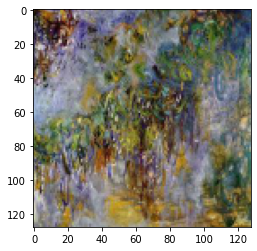

In [39]:
plt.imshow(style_images[3])

In [40]:
content_images = []
for filename in glob.glob('../dataset_content/*.jpg'):
    image = np.array(Image.open(filename))
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    content_images.append(image)

content_images = np.array(content_images)

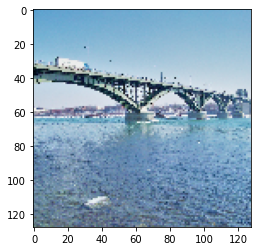

In [41]:
plt.imshow(content_images[3])

In [42]:
train = (style_images[0:4], content_images[0:4])

In [43]:
train[0].shape

(4, 128, 128, 3)

In [54]:
f_input_style = tfl.Input(input_size)
f_input_content = tfl.Input(input_size)

f_encoder = encoder(f_input_content)
f_decoder = decoder(f_encoder)
f_en_deco = encoder(f_decoder)

f_transform1 = transformer(f_input_content)
f_transform2 = transformer(f_decoder)
f_discr_1 = discriminator(f_input_style)
f_discr_2 = discriminator(f_decoder)

full_model = Model([f_input_style, f_input_content], [f_encoder, f_decoder, f_transform1, f_transform2, f_discr_1, f_discr_2, f_en_deco])

In [55]:
full_model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 16)           1047312     input_11[0][0]                   
                                                                 functional_3[1][0]               
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 128, 128, 3)  747011      functional_1[1][0]               
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 128, 128, 3) 0                                

## Entraînement

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

In [56]:
epochs = 300000
for epoch in range(epochs):
    for i in range(4):
        style = train[0]
        content = train[1]
        with tf.GradientTape() as tape:
            out_encoder, out_decoder, transform_input, transform_reconstruction, discr3, discr2, encode_decoded = full_model([style, content])
            
            """
            out_encoder = encoder(content, training=True)
            out_decoder = decoder(out_encoder, training=True)
            encode_decoded = encoder(out_decoder, training=True)
            
            discr1 = discriminator(content, training=True)
            discr2 = discriminator(out_decoder, training=True)
            discr3 = discriminator(style, training=True)
            
            transform_input = transformer(content)
            transform_reconstruction = transformer(out_decoder)"""
            
            discr_loss = discriminator_loss(discr3, discr2)
            transformed_loss = transformed_image_loss(transform_input, transform_reconstruction)
            style_aware_loss = style_aware_content_loss(out_encoder, encode_decoded)
            
            loss_value = discr_loss + transformed_loss + style_aware_loss
            
        grads = tape.gradient(loss_value, full_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, full_model.trainable_weights))
    
    if epoch == 200000:
        optimizer.lr.assign(0.00002)

KeyboardInterrupt: 